In [220]:
import fitz
import cv2
import csv
import numpy as np
import matplotlib.pyplot as plt

In [90]:
pdf_document = "./PDF/Test.pdf"
doc = fitz.open(pdf_document)
for page_number in range(doc.page_count):
    page = doc[page_number]
    pix = page.get_pixmap()
    pix.save(f"page_{page_number + 1}.png")


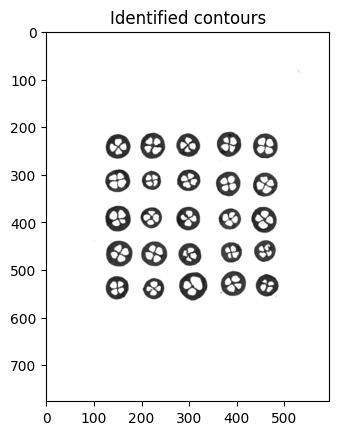

NameError: name 'contours' is not defined

In [ ]:
# Read image
img = cv2.imread('./page_1.png')
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
plt.imshow(gray_img, cmap='gray')
# plt.axis('off') # Quitar bordes?
plt.title("Identified contours")
plt.show() 


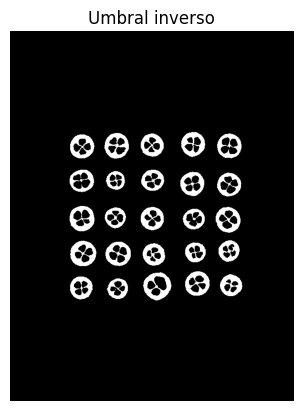

In [212]:
# Pre processing
#cv2.GaussianBlur(src, ksize, sigmaX[, dst[, sigmaY[, borderType]]])
blurred = cv2.GaussianBlur(gray_img, (1, 1), 0)
_, binary = cv2.threshold(blurred, 100, 255, cv2.THRESH_BINARY_INV)
plt.imshow(binary, cmap='gray')
plt.title("Umbral inverso")
plt.axis('off')
plt.show()


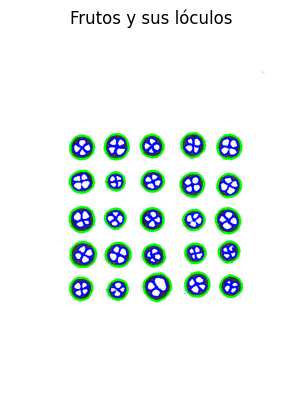

Fruto 0: 3 lóculos detectados
Fruto 5: 4 lóculos detectados
Fruto 10: 4 lóculos detectados
Fruto 15: 3 lóculos detectados
Fruto 19: 5 lóculos detectados
Fruto 25: 4 lóculos detectados
Fruto 30: 4 lóculos detectados
Fruto 35: 4 lóculos detectados
Fruto 40: 5 lóculos detectados
Fruto 46: 4 lóculos detectados
Fruto 51: 2 lóculos detectados
Fruto 54: 4 lóculos detectados
Fruto 59: 4 lóculos detectados
Fruto 64: 4 lóculos detectados
Fruto 69: 5 lóculos detectados
Fruto 75: 3 lóculos detectados
Fruto 79: 4 lóculos detectados
Fruto 84: 4 lóculos detectados
Fruto 89: 3 lóculos detectados
Fruto 93: 2 lóculos detectados
Fruto 97: 4 lóculos detectados
Fruto 102: 3 lóculos detectados
Fruto 106: 4 lóculos detectados
Fruto 111: 4 lóculos detectados
Fruto 116: 4 lóculos detectados


True

In [ ]:
# Detectar contornos (modo TREE para jerarquía, sin filtrar)
contours, hierarchy = cv2.findContours(binary, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Convertir la jerarquía a un arreglo para facilitar el acceso
hierarchy = hierarchy[0]  # La jerarquía viene en un arreglo anidado

# Detectar frutos (contornos externos) y sus lóculos
fruit_locus_map = {}  # Diccionario para mapear frutos y sus lóculos
for i in range(len(contours)):
    # Identificar contornos externos (frutos)
    if hierarchy[i][3] == -1:  # Sin padre => es un fruto
        fruit_locus_map[i] = []  # Inicializar lista de lóculos para este fruto

    # Si tiene un padre, es un lóculo
    elif hierarchy[i][3] != -1:  # Tiene un padre => es un lóculo
        parent_index = hierarchy[i][3]  # Índice del fruto (padre)
        if parent_index in fruit_locus_map:
            fruit_locus_map[parent_index].append(i)  # Asociar lóculo al fruto


# Dibujar frutos y sus lóculos
image_with_contours = image.copy()
for fruit_idx, loculi in fruit_locus_map.items():
    # Dibujar contorno del fruto
    cv2.drawContours(image_with_contours, contours, fruit_idx, (0, 255, 0), 3)

    # Dibujar contornos de los lóculos asociados al fruto
    for loculus_idx in loculi:
        cv2.drawContours(image_with_contours, contours, loculus_idx, (255, 0, 0), 2)

# Mostrar la imagen con frutos y lóculos identificados
plt.imshow(cv2.cvtColor(image_with_contours, cv2.COLOR_BGR2RGB))
plt.title("Frutos y sus lóculos")
plt.axis('off')
plt.show()

# Imprimir resultados
for fruit_idx, loculi in fruit_locus_map.items():
    print(f"Fruto {fruit_idx}: {len(loculi)} lóculos detectados")
output_path = "imagen_anotada.png"  # Especifica el nombre y formato del archivo
cv2.imwrite(output_path, image_with_contours)


In [218]:
# Contar frutos (contornos externos)
fruit_count = 0
for i in range(len(contours)):
    if hierarchy[i][3] == -1:  # Sin padre => es un fruto
        fruit_count += 1

# Imprimir el número de frutos detectados
print(f"Número total de frutos detectados: {fruit_count}")

Número total de frutos detectados: 25


In [225]:
# Crear una lista para almacenar los datos
# Cada elemento de la lista será un diccionario con el formato {"ID_Fruit": ..., "N_Locules": ...}
results = []

# Procesar el diccionario `fruit_locus_map` y asignar nombres secuenciales a los frutos
# Enumeramos los frutos para asignarles un ID secuencial desde "Fruit_1"
for index, (fruit_id, loculi) in enumerate(fruit_locus_map.items(), start=1):
    # `index` será el número secuencial del fruto (1, 2, 3, ...)
    # `len(loculi)` cuenta el número de lóculos asociados al fruto
    results.append({"ID_Fruit": f"Fruit_{index}", "N_Locules": len(loculi)})

# Definir el nombre del archivo CSV de salida
# El archivo se guardará en el directorio actual con el nombre "numero_loculos_por_fruto_ordenado.csv"
output_csv = "numero_loculos_por_fruto_ordenado.csv"

# Guardar los resultados en un archivo CSV
# Abrimos el archivo en modo escritura ("w") y usamos `newline=""` para evitar líneas en blanco adicionales
with open(output_csv, mode="w", newline="") as file:
    # Crear un escritor de CSV con los encabezados definidos
    writer = csv.DictWriter(file, fieldnames=["ID_Fruit", "N_Locules"])
    
    # Escribir la fila de encabezado (columnas) en el archivo CSV
    writer.writeheader()
    
    # Escribir las filas de datos en el archivo
    writer.writerows(results)

# Imprimir un mensaje de confirmación para indicar que los resultados han sido guardados correctamente
print(f"Resultados guardados en: {output_csv}")


Resultados guardados en: numero_loculos_por_fruto_ordenado.csv
